# Text and code

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

In [6]:
import micropip
await micropip.install(["ipympl", 'plotly'])

In [1]:
print('hello world')

hello world


In [2]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import plotly.subplots as sp
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe'

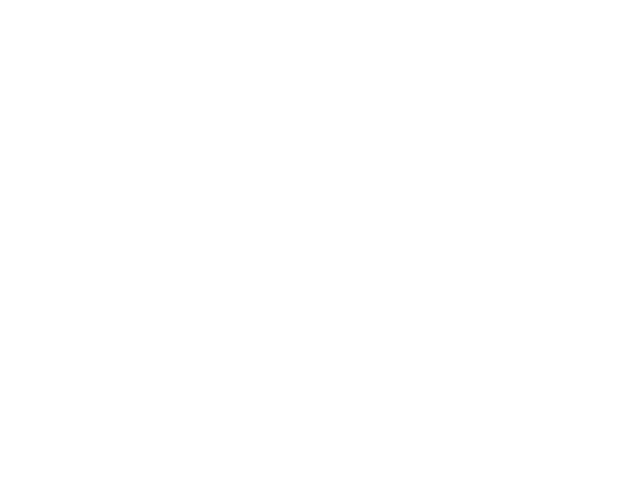

In [3]:
plt.figure()
plt.rcParams.update({'font.size': 12, 'lines.linewidth': 2})

def shape_functions(total_length, num_nodes, node_x):
    l = total_length / (num_nodes - 1)

    if node_x == 0:
        x = np.array([node_x, node_x + l])
        y = np.array([1.0, 0.0])
    elif node_x == total_length:
        x = np.array([node_x - l, node_x])
        y = np.array([0.0, 1.0])
    else:
        x = np.array([node_x - l, node_x, node_x + l])
        y = np.array([0.0, 1.0, 0.0])

    return x, y

def shape_functions_for_plot(num_nodes, beam_length = 15):

    x_positions = np.linspace(0, beam_length, num_nodes)

    data = {}

    for node_num, x_coords in enumerate(x_positions):

        x, y = shape_functions(beam_length, num_nodes, x_coords)
        data[node_num + 1] = {'x': x, 'y': y}

    return data

In [4]:
def linear_lagrange_shape_function(x, nodes_x_values, nodes_displacements):
    """
    Compute the linear Lagrange shape function for a given x.
    Args:
        x (float): The x-coordinate.
        x0 (float): Left node position.
        x1 (float): Right node position.
    Returns:
        float: The shape function value.
    """

    ratio = (x - nodes_x_values[0]) / (nodes_x_values[1] - nodes_x_values[0])

    return (1 - ratio) * nodes_displacements[0] + ratio * nodes_displacements[1]

def function(x):
    """
    Define the function to be plotted.
    Args:
        x (numpy.ndarray): Input values.
    Returns:
        numpy.ndarray: Corresponding function values.
    """
    return np.sin(x) * 0.14*x

def shape_functions_applied(num_elements):
    """
    Plot linear Lagrange shape functions on a beam.
    Args:
        num_elements (int): Number of elements (segments).
    """

    beam_length = 15

    num_nodes = num_elements + 1
    x_at_nodes = np.linspace(0, beam_length, num_nodes)

    y_at_nodes = function(x_at_nodes)

    x_data = np.linspace(0, beam_length, 1000)

    # Use NumPy to compute y_vals efficiently
    y_vals = np.zeros_like(x_data)

    for element_number in range(num_elements):
        mask = (x_at_nodes[element_number] <= x_data) & (x_data <= x_at_nodes[element_number + 1])
        y_vals[mask] = linear_lagrange_shape_function(x_data[mask], x_at_nodes[element_number:element_number + 2], y_at_nodes[element_number:element_number + 2])

    return x_data, function(x_data), y_vals

In [5]:
# Colors
grey = '#eeeeee'  # light grey fill

# Prepare all the graphs that are to be plotted
range_elements = np.concatenate((np.arange(1, 7, 1), np.arange(7, 35, 4), np.arange(35, 55, 8)))

# Create subplots
fig = sp.make_subplots(rows=1, cols=2, subplot_titles=("Shape functions", "Exact and approximated solution"))

base_traces_left = 2  # Number of traces in the left plot that are always visible
base_traces_right = 0  # Number of traces in the right plot that are always visible

# Add traces to the subplots
x_data, y_data, y_vals = shape_functions_applied(10)

# Add left plot traces (Cumulative Influx and Cumulative Outflux)
fig.add_trace(
    go.Scatter(
        visible=True,  # Show for the first value of a
        x=x_data,
        y=y_data,
        # line=dict(color='#6a8ba4'),
        mode='lines',
        name='Exact solution'
    ),
    row=1,
    col=2
)


# Add traces to the subplots
for a in range_elements:

    x_data, y_data, y_vals = shape_functions_applied(a)

    fig.add_trace(
        go.Scatter(
            visible = True if a == range_elements[0] else False,  # Show for the first value of a
            x=x_data,
            y=y_vals,
            # line=dict(color='#FFA500'),
            mode='lines',
            name='Numerical solution'
        ),
        row=1,
        col=2
    )


# Add traces to the subplots
for a in range_elements:

    data = shape_functions_for_plot(a + 1)

    for i in range(1, a + 2):

        info = data[i]
        x, y = info['x'], info['y']

        # Add right plot traces (Cumulative Outflux for each 'a' value)
        fig.add_trace(
            go.Scatter(
                visible = True if a == range_elements[0] else False,
                x=x,
                y=y,
                mode='lines',
                name=f'Node shape for node {i}'
            ),
            row=1,
            col=1
        )

# Create and add slider
steps = []
for i in range(0, range_elements.shape[0]):

    a = range_elements[i]
    visarray = [False] * len(fig.data)

    visarray[0] = True
    visarray[i + 1] = True

    start_of_second_plot = 1 + len(range_elements)

    if i==0:
        start_index=start_of_second_plot
    else:
        start_index = start_of_second_plot + np.sum(range_elements[0:i]) + i

    num_lines = range_elements[i] + 1
    end_index = start_index + num_lines

    visarray[start_index:end_index] = [True] * (end_index - start_index)
    
    step = dict(
        method="update",
        args=[{"visible": visarray}],
        label=str(round(range_elements[i], 1))
    )
    steps.append(step)

sliders = [dict(
    active=0,  # Show the first value of 'a' initially
    currentvalue={"prefix": r"Number of elements: "},
    steps=steps
)]

fig.update_layout(
    sliders=sliders,
    title="Applying shape functions",
    legend_title="Legend",
    legend=dict(
        x=1.05,  # Adjust the legend position
        y=0.5
    )
)

fig.update_xaxes(title_text='x', row=1, col=1, range=[x_data[0], x_data[-1]])
fig.update_xaxes(title_text='x', row=1, col=2, range=[x_data[0], x_data[-1]])

# Update y-axis properties
fig.update_yaxes(title_text='Node shape value', row=1, col=1, range=[-0.1, 1.1])
fig.update_yaxes(title_text='y', row=1, col=2, range=[-2.1, 2.1])

fig.show()

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from ipywidgets import interact, interactive
from IPython.display import clear_output, display, HTML

import numpy as np
from scipy import integrate

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation

def solve_lorenz(
  N=10, angle=0.0, max_time=4.0, 
  sigma=10.0, beta=8./3, rho=28.0):

    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1], projection='3d')
    ax.axis('off')

    # prepare the axes limits
    ax.set_xlim((-25, 25))
    ax.set_ylim((-35, 35))
    ax.set_zlim((5, 55))
    
    def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
        """Compute the time-derivative of a Lorenz system."""
        x, y, z = x_y_z
        return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

    # Choose random starting points, uniformly distributed from -15 to 15
    np.random.seed(1)
    x0 = -15 + 30 * np.random.random((N, 3))

    # Solve for the trajectories
    t = np.linspace(0, max_time, int(250*max_time))
    x_t = np.asarray([integrate.odeint(lorenz_deriv, x0i, t)
                      for x0i in x0])
    
    # choose a different color for each trajectory
    colors = plt.cm.viridis(np.linspace(0, 1, N))

    for i in range(N):
        x, y, z = x_t[i,:,:].T
        lines = ax.plot(x, y, z, '-', c=colors[i])
        plt.setp(lines, linewidth=2)

    ax.view_init(30, angle)
    plt.show()

    return t, x_t

w = interactive(solve_lorenz, angle=(0.,360.), max_time=(0.1, 4.0), 
                N=(0,50), sigma=(0.0,50.0), rho=(0.0,50.0))
display(w)

interactive(children=(IntSlider(value=10, description='N', max=50), FloatSlider(value=0.0, description='angle'…